In [1]:
import numpy as np
import scipy
import matplotlib.pyplot as plt
from bosonStar import *
from util import *

from ctypes import *
file = "./testing.so"
my_func = CDLL(file)

#Case: Middle
massInCU = 2e-77
aInCU = 1e-73
totalMassInCU = 0.1
dtInCU = 2500.0
bigT = 1000

/home/kklee/anaconda3/lib/python3.11/site-packages/scipy/integrate/_odepack_py.py:248: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)


A2=  -0.3197640202007044  X= 20.65212130424261
A2=  -0.4847073570464445  X= 20.0997201994404
A2=  -0.4996237064856289  X= 40.0
A2=  -0.5019378672755319  X= 16.740033480066963
A2=  -0.5018381151828868  X= 18.401316802633605
A2=  -0.5018730652697496  X= 15.347950695901392
A2=  -0.5019295973148135  X= 22.058364116728235
A2=  -0.5019295973148135  X= 22.058364116728235
MU= 0.3181619365115217 MASS= 0.09999012221832808
FAR POINT: 156400 500000


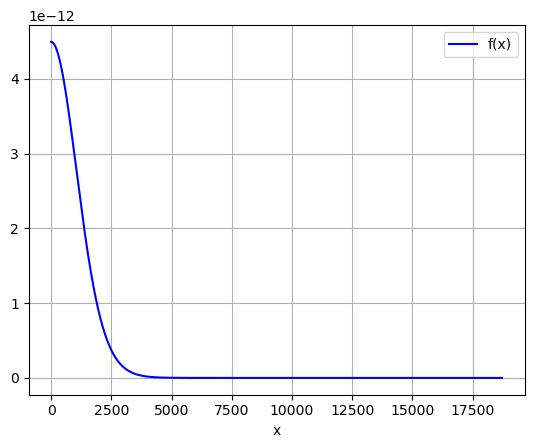

(2500,)


In [2]:
bosonStar = outputProfile(massInCU, aInCU, totalMassInCU, 500)
x = bosonStar["x"]
psi = bosonStar["profile"]

dx = x[1]-x[0]
for i in range(2000):
    x = np.append(x, x[-1]+dx)
    psi = np.append(psi, psi[-1])

print(x.shape)

In [3]:
totalMass = massSIToPlanckUnit(massCodeUnitToSI(totalMassInCU))
m = massSIToPlanckUnit(massCodeUnitToSI(massInCU))
a = lengthSIToPlanckUnit(lengthCodeUnitToSI(aInCU))
N = totalMass/m
Ra = np.sqrt(a/m/m/m)
omegaA = m*m/np.abs(a)
epsilon = 1.0/omegaA/m/Ra/Ra
a0 = np.sqrt(1.0/omegaA/m)
delta = 4.0*np.pi*a*N/a0
GM = totalMass/Ra/Ra/Ra/omegaA/omegaA

print("R:", Ra)
print("Omega:" ,omegaA)
print("Epsilon (Should be 1):", epsilon)
print("Delta:", delta)
print("New G:", GM)

R: 3.8684718785837514e+40
Omega: 3.656129092998465e-43
Epsilon (Should be 1): 1.0000000000000002
Delta: 14.839459489461666
New G: 1.180886665279879


In [4]:
x = lengthSIToPlanckUnit(lengthCodeUnitToSI(x))/Ra
psi = np.sqrt(densitySIToPlanckUnit(densityCodeUnitToSI(psi))/totalMass)*np.power(Ra, 3.0/2.0)
normalization = scipy.integrate.simpson(4.0*np.pi*x*x*np.absolute(psi)*np.absolute(psi), x=x)
psi = psi/normalization
psi = psi.astype(complex)

for index, value in enumerate(psi):
    if(value<1e-5):
        psi[index] = 0.0

psi = x*psi

size = len(psi)
dt = timeSIToPlanckUnit(timeCodeUnitToSI(dtInCU))*omegaA
dx = x[1]-x[0]

print(psi)
print("DX:", dx)
print("DT:", dt)

[0.00258441+0.j 0.00774838+0.j 0.01289782+0.j ... 0.        +0.j
 0.        +0.j 0.        +0.j]
DX: 0.08851117335848695
DT: 0.08351027137908527


In [5]:
T = np.zeros((size,size)).astype(complex)
TSph = np.zeros((size,size)).astype(complex)
Q = np.zeros((size,size)).astype(complex)
V2Grav = np.zeros((size,size)).astype(complex)
I = np.identity(size).astype(complex)
phi = np.zeros((size))

In [6]:
def setupT():
    global T
    for i in range(size):
        if i==0:
            T[i][i] = -3.0
            T[i][i+1] = 1.0
        elif i==size-1:
            T[i][i] = -1.0
            T[i][i-1] = 1.0
        else:
            T[i][i] = -2.0
            T[i][i+1] = 1.0
            T[i][i-1] = 1.0

    T = -1.0/2.0/dx/dx*T

def setupQ():
    global Q
    for i in range(size):
        Q[i][i] = delta*np.absolute(psi[i]/x[i])*np.absolute(psi[i]/x[i])

def setupV2Grav():
    global V2Grav, phi

    rho = np.absolute(psi)*np.absolute(psi)/x/x
    rho_c = (c_double * size)(*rho)
    phi_c = (c_double * size)(*np.absolute(phi))
    my_func.findGravRho(rho_c, phi_c, c_int(size), c_double(dx))
    for i in range(size):
        phi[i] = phi_c[i] * GM

    for i in range(size):
        V2Grav[i][i] = phi[i]

def setupU1U2():
    global U1, U2
    U1 = I + 1.0j*dt/2.0*(T+Q+V2Grav)
    U2 = I - 1.0j*dt/2.0*(T+Q+V2Grav)

In [7]:
def findMass():
    for i in range(size):
        if(i != 0):
            temp = scipy.integrate.simpson(4.0*np.pi*np.absolute(psi[:i])*np.absolute(psi[:i]), x=x[:i])
            if(temp > 0.99):
                return i
    return size-1

[-3.86469928e-07 -1.66063827e-07  2.65294002e-08 -1.49604746e-09
 -1.92036843e-09 -2.34252184e-09 -2.76177647e-09 -3.17766439e-09
 -3.58964014e-09 -3.99717384e-09 -4.39968586e-09 -4.79656353e-09
 -5.18734396e-09 -5.57154668e-09 -5.94858449e-09 -6.31793342e-09
 -6.67913277e-09 -7.03170258e-09 -7.37516024e-09 -7.70902741e-09
 -8.03282068e-09 -8.34609062e-09 -8.64844266e-09 -8.93950982e-09
 -9.21893501e-09 -9.48639998e-09 -9.74165448e-09 -9.98448832e-09
 -1.02146616e-08 -1.04319123e-08 -1.06360314e-08 -1.08268913e-08
 -1.10044244e-08 -1.11686235e-08 -1.13195787e-08 -1.14574600e-08
 -1.15824624e-08 -1.16947862e-08 -1.17946458e-08 -1.18822402e-08
 -1.19577429e-08 -1.20213421e-08 -1.20732694e-08 -1.21137742e-08
 -1.21430687e-08 -1.21613914e-08 -1.21691102e-08 -1.21667439e-08
 -1.21549275e-08 -1.21343704e-08 -1.21057845e-08 -1.20697384e-08
 -1.20265337e-08 -1.19762440e-08 -1.19189082e-08 -1.18546934e-08
 -1.17839404e-08 -1.17071371e-08 -1.16248479e-08 -1.15376292e-08
 -1.14459990e-08 -1.13504

/tmp/ipykernel_386215/1027521224.py:16: RuntimeWarning: divide by zero encountered in divide
  quantumPotential = -hBarCU*hBarCU/2.0/massInCU*(d2Rhodx + 2.0/(x*Ra*1.616e-35*100*6.77193e-6)*dRhodx)/np.sqrt(rhoTemp)
/tmp/ipykernel_386215/1027521224.py:16: RuntimeWarning: invalid value encountered in divide
  quantumPotential = -hBarCU*hBarCU/2.0/massInCU*(d2Rhodx + 2.0/(x*Ra*1.616e-35*100*6.77193e-6)*dRhodx)/np.sqrt(rhoTemp)
/tmp/ipykernel_386215/1027521224.py:18: RuntimeWarning: invalid value encountered in divide
  plt.plot(x*Ra*1.616e-35*100*6.77193e-6, pressureGradient/rhoTemp)


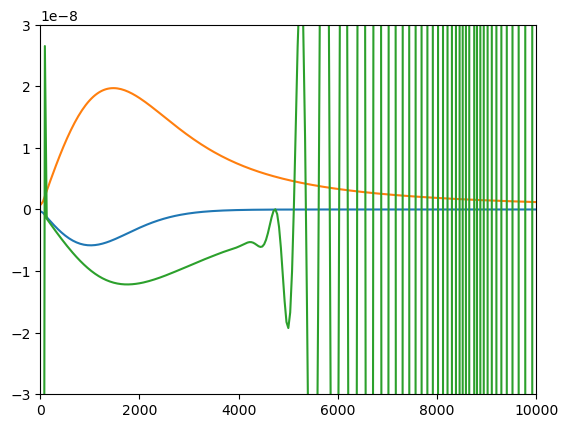

In [15]:
#Temporary
#massInCU = 2e-77
#aInCU = 1e-73
#totalMassInCU = 0.1
hBarInCU = 1.1977151493389159e-76
setupV2Grav()
np.set_printoptions(threshold=np.inf)

rhoTemp = (np.absolute(psi)/x)*(np.absolute(psi)/x)/Ra/Ra/Ra*totalMass*5.1550e96*0.001*1.619e-18
pressure = 2.0*np.pi*aInCU*hBarInCU*hBarInCU/massInCU/massInCU/massInCU*rhoTemp*rhoTemp
pressureGradient = np.gradient(pressure, x*Ra*1.616e-35*100*6.77193e-6)
gravitationalPotential = phi*Ra*Ra*omegaA*omegaA*1.616e-35*100*6.77193e-6*1.616e-35*100*6.77193e-6/5.391e-44/5.391e-44/2.03017e5/2.03017e5

dRhodx = np.gradient(np.sqrt(rhoTemp), x*Ra*1.616e-35*100*6.77193e-6)
d2Rhodx = np.gradient(dRhodx, x*Ra*1.616e-35*100*6.77193e-6)
quantumPotential = -hBarCU*hBarCU/2.0/massInCU*(d2Rhodx + 2.0/(x*Ra*1.616e-35*100*6.77193e-6)*dRhodx)/np.sqrt(rhoTemp)

plt.plot(x*Ra*1.616e-35*100*6.77193e-6, pressureGradient/rhoTemp)
plt.plot(x*Ra*1.616e-35*100*6.77193e-6, np.gradient(gravitationalPotential, x*Ra*1.616e-35*100*6.77193e-6))
plt.plot(x*Ra*1.616e-35*100*6.77193e-6, np.gradient(quantumPotential, x*Ra*1.616e-35*100*6.77193e-6)/massInCU)

plt.xlim(0.0,10000.0)
plt.ylim(-3e-8,3e-8)
print(np.gradient(quantumPotential, x*Ra*1.616e-35*100*6.77193e-6)/massInCU)

0 0.0 0.08351027137908527 0.05839835939919027
1 0.08351027137908527 0.1 0.05840230557444625
2 0.18351027137908527 0.1 0.058409198411836415
3 0.28351027137908524 0.1 0.058419021479678
4 0.3835102713790852 0.1 0.05843175278421733
5 0.4835102713790852 0.1 0.05844736335508801
6 0.5835102713790852 0.1 0.058465818508714656
7 0.6835102713790852 0.1 0.05848707842408993
8 0.7835102713790851 0.1 0.05851109724057548
9 0.8835102713790851 0.1 0.058537824776606934
10 0.9835102713790851 0.1 0.058567206691678766
11 1.0835102713790852 0.1 0.05859918445668457
12 1.1835102713790853 0.1 0.0586336970956275
13 1.2835102713790854 0.1 0.05867068020512877
14 1.3835102713790854 0.1 0.058710067486629984
15 1.4835102713790855 0.1 0.05875178985502833
16 1.5835102713790856 0.1 0.058795778577017586
17 1.6835102713790857 0.1 0.05884196347555253
18 1.7835102713790858 0.1 0.05889027410309512
19 1.8835102713790859 0.1 0.05894063899733375
20 1.983510271379086 0.1 0.05899298678651257
21 2.083510271379086 0.1 0.05904724752

KeyboardInterrupt: 

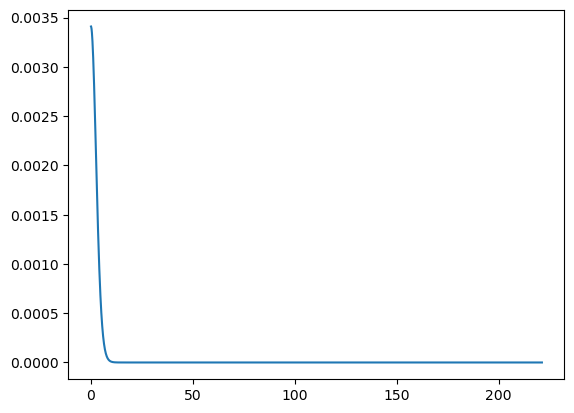

In [9]:
setupT()
setupQ()
setupV2Grav()
setupU1U2()
currentT = 0.0

#Record
centralDensity = []
R99 = []
ts = []
cfls = []
gravitationalForce = []
pressureGradient = []
quantumPressure = []

#Pertubation
oldGM = GM
newGM = GM*1.2

for t in range(bigT):
    #Pertubation
    if(currentT<6.0):
        GM = newGM
    if(currentT>=6.0):
        GM = oldGM

    setupQ()
    setupV2Grav()
    setupU1U2()
    psi = np.linalg.solve(U2, np.dot(U1,psi))

    print(t, currentT, dt, np.absolute(psi[0])/x[0])

    currentT = currentT + dt
    dt = min(0.1, 0.1*dx/abs((np.angle(psi[1])-np.angle(psi[0]))/(dx*Ra)/m/Ra/omegaA))

    #Record
    if(GM == oldGM):
        #Record
        rho0 = (np.absolute(psi[0])*np.absolute(psi[0])/x[0]/x[0])/Ra/Ra/Ra*totalMass
        rho1 = (np.absolute(psi[1])*np.absolute(psi[1])/x[1]/x[1])/Ra/Ra/Ra*totalMass
        rho2 = (np.absolute(psi[2])*np.absolute(psi[2])/x[2]/x[2])/Ra/Ra/Ra*totalMass
        Q0 = -((-2.0*np.sqrt(rho0) + 2.0*np.sqrt(rho1))/(dx*Ra)/(dx*Ra) + 2.0/(x[0]*Ra)*(np.sqrt(rho1)-np.sqrt(rho0))/(dx*Ra))/np.sqrt(rho0)/2.0/m
        Q1 = -((np.sqrt(rho0) -2*np.sqrt(rho1) + np.sqrt(rho2))/(dx*Ra)/(dx*Ra) + 2.0/(x[1]*Ra)*(np.sqrt(rho2)-np.sqrt(rho1))/(dx*Ra))/np.sqrt(rho1)/2.0/m

        cfls.append((np.angle(psi[1])-np.angle(psi[0]))/(dx*Ra)/m/Ra/omegaA*dt/dx)
        R99.append(findMass())
        centralDensity.append(np.absolute(psi[0])*np.absolute(psi[0])/x[0]/x[0])
        ts.append(currentT)
        gravitationalForce.append((phi[1]-phi[0])/dx)
        pressureGradient.append(4.0*np.pi*a/m/m/m*(rho1-rho0)/(dx*Ra)/Ra/omegaA/omegaA)
        quantumPressure.append((Q1-Q0)/m/(dx*Ra)/Ra/omegaA/omegaA)

    if t%100 == 0:
        plt.plot(x, np.absolute(psi)*np.absolute(psi)/x/x)

plt.xlabel(r"$r$ (dimensionless)")
plt.ylabel(r"$\left | \psi^2 \right |$ (dimensionless)")
plt.show()

In [ ]:
plt.plot(ts, centralDensity)
plt.xlabel(r"$t$ (dimensionless)")
plt.ylabel(r"$\left | \psi^2 \right |$ (dimensionless)")
plt.show()

In [ ]:
sp = np.fft.fft(centralDensity)
freq = np.fft.fftfreq(len(centralDensity), d=dt)*omegaA/5.391247e-44

plt.plot(freq, np.absolute(sp))
plt.xlim(0.01,0.4)
plt.ylim(0.0,5.0)
plt.xlabel("f (1/s)")

In [ ]:
print(freq[1]-freq[0])
for i in range(len(freq)-1):
    if(freq[i] > 0.0 and np.absolute(sp[i]) > 0.5 and np.absolute(sp[i])>np.absolute(sp[i+1]) and np.absolute(sp[i])>np.absolute(sp[i-1])):
        print(freq[i], np.absolute(sp[i]))

In [ ]:
plt.plot(ts, R99)
plt.xlabel(r"$t$ (dimensionless)")
plt.ylabel(r"R99")
plt.show()

In [ ]:
sp = np.fft.fft(R99)
freq = np.fft.fftfreq(len(R99), d=dt)*omegaA/5.391247e-44

plt.plot(freq, np.absolute(sp))
plt.xlim(0.01,0.4)
plt.ylim(0.0,100000)
plt.xlabel("f (1/s)")

In [ ]:
print(freq[1]-freq[0])
for i in range(len(freq)-1):
    if(freq[i] > 0.0 and np.absolute(sp[i]) > 10000 and np.absolute(sp[i])>np.absolute(sp[i+1]) and np.absolute(sp[i])>np.absolute(sp[i-1])):
        print(freq[i], np.absolute(sp[i]))

In [ ]:
plt.plot(x, np.absolute(psi)*np.absolute(psi)/x/x)
print(np.absolute(psi)/x)

In [ ]:
plt.plot(ts, cfls)
plt.xlabel(r"$t$ (dimensionless)")
plt.ylabel(r"cfl")
plt.ylim(-0.3,0.3)
plt.show()

In [ ]:
sp = np.fft.fft(pressureGradient)
freq = np.fft.fftfreq(len(pressureGradient), d=dt)*omegaA/5.391247e-44

sp2 = np.fft.fft(quantumPressure)

for i in range(len(freq)):
    if(freq[i]<=-10.0 or freq[i]>=10.0):
        sp[i] = 0.0
#        sp2[i] = 0.0

pressureGradient = np.fft.ifft(sp)
#quantumPressure = np.fft.ifft(sp2)

plt.plot(ts, gravitationalForce)
plt.plot(ts, pressureGradient)
plt.plot(ts, quantumPressure)
plt.xlabel(r"$t$ (dimensionless)")
plt.ylabel(r"Different Forces")
plt.show()

In [ ]:
sp = np.fft.fft(pressureGradient)
freq = np.fft.fftfreq(len(pressureGradient), d=dt)*omegaA/5.391247e-44

plt.plot(freq, np.absolute(sp))
#plt.xlim(0.01,0.4)
#plt.ylim(0.0,100000)
plt.xlabel("f (1/s)")

Middle
0.071-0.081			M1 (M2: 0.142-0.162, M3: 0.213-0.243, M4: 0.284-0.324, M5: 0.355-0.405)
0.132-0.137			M1?
0.158-0.163			M2
0.193-0.204			M1?
0.239-0.249			M3
0.295-0.305			M4
0.361-0.371			M5

0.076-0.086			M1
0.132-0.142			M1?
0.158-0.168			M2

Small
0.097-0.107		M1
0.163-0.173		M1?
0.214-0.224		M2
0.270-0.280		M1?
0.341-0.351		M3
0.432-0.443		M4
0.534-0.544		M5
0.651-0.661		M6

Heavy
0.031-0.037		M1
0.058-0.065		M2
0.072-0.078		M?
0.082-0.089		M?
0.099-0.167 	M3
0.116-0.123		M4
0.140-0.147		M5
0.167-0.173		M6?
0.194-0.201 	M7?